In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Loading trainning data ....

df_train = pd.read_csv('train_s.csv')
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


# Data Cleaning and preprocessing

In [4]:
#Counting or checking total number of null values 
df_train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [5]:
#Checking total number number of credits in categorised format

df_train['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [6]:
#Replacing NA values with most frequently occured variables because we have to deal with missing values
#Here we don't drop na values because their presence is significance if we drop then might have posssibilities
#that it will impact the  performance of the model


df_train['Credit_Product']=df_train['Credit_Product'].fillna(df_train['Credit_Product'].mode())

In [7]:
# Converting categorical variables into numerical

df_train['Credit_Product']= df_train['Credit_Product'].apply(lambda x: 1 if x=='Yes' else 0 )

df_train['Is_Active']= df_train['Is_Active'].apply(lambda x: 1 if x=='Yes' else 0)

df_train['Gender'] = df_train['Gender'].apply(lambda x : 1 if x=='Male' else 0)

In [8]:
#Counting categorised occupations

df_train['Occupation'].value_counts()

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

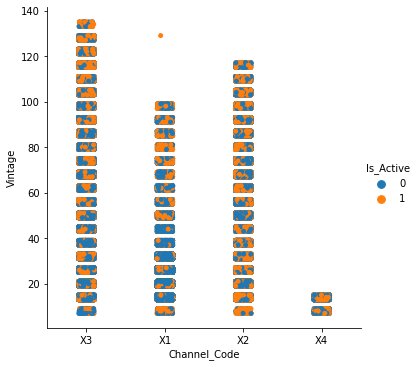

In [9]:
#Finding insights

sns.catplot(y='Vintage',x='Channel_Code',hue='Is_Active',data=df_train)

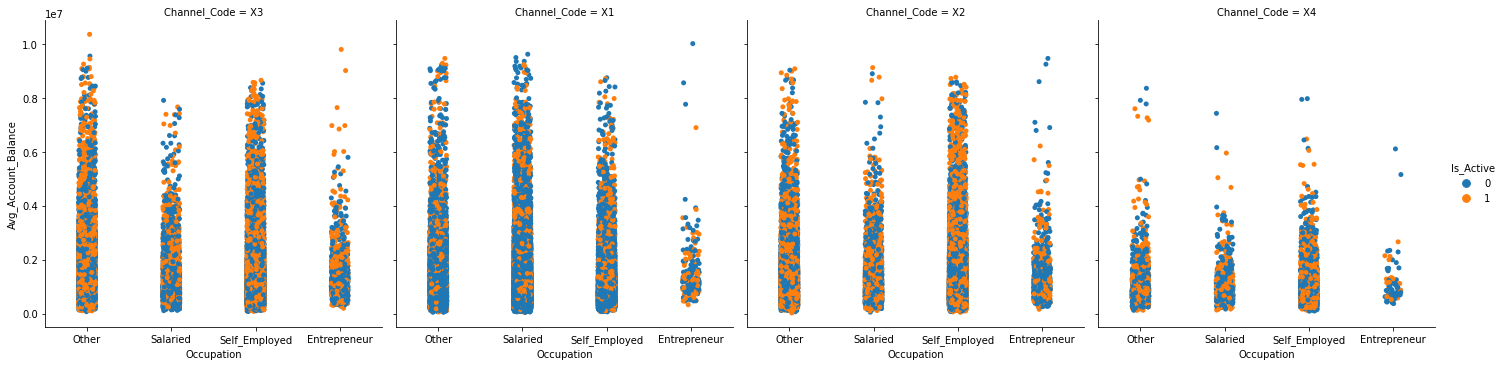

In [10]:
#Checking which channel is active for three months considering the average balance

sns.catplot(y='Avg_Account_Balance',x='Occupation',hue='Is_Active',col='Channel_Code',data=df_train)

In [11]:
#From above visualisation we can say that self employed and others are more active and have good significance 
# in every channel so we will replace according to the significance

df_train['Occupation'].replace(['Self_Employed','Other','Salaried','Entrepreneur'],[4,3,2,1],inplace=True)

In [12]:
#Counting region code as it has multiple categories so we need to find a solution where they can deal with it

df_train['Region_Code'].value_counts()

RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

# Feature Engineering 

In [13]:
#Applying one hot encoding in region code 

region_code=pd.get_dummies(df_train['Region_Code'])
region_code.head()

,RG250,RG251,RG252,RG253,RG254,RG255,RG256,RG257,RG258,RG259,...,RG275,RG276,RG277,RG278,RG279,RG280,RG281,RG282,RG283,RG284
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# Concatenating region code with original data

df_train = pd.concat([df_train,region_code],axis=1)

In [15]:
#Taking only top 10 frequency because if you consider each and every categories then it will create sparse matrix
#might be posibilitis that it will impact performance of your model

#top_20_region = [x for x in df_train['Region_Code'].value_counts().head(10).index]
#top_20_region

In [16]:
#Taking top 20 Region code doing frequency encoding

#for label in top_20_region:
 #   df_train[label] = np.where(df_train['Region_Code']==label,1,0)
#df_train[['Region_Code'] + top_20_region].head(5)    

In [17]:
# Applying one hot encoding into channel code

channel_code =pd.get_dummies(df_train['Channel_Code'])
channel_code.head()

,X1,X2,X3,X4
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,1,0,0,0
4,1,0,0,0


In [18]:
#Concatenating channel codes with original data

df_train = pd.concat([df_train,channel_code],axis =1)

In [19]:
#Dropping columns 

df_train.drop(['ID','Region_Code','Channel_Code'],axis =1 ,inplace=True)

In [20]:
target_col=df_train['Is_Lead']
target_col

0         0
1         0
2         0
3         0
4         0
         ..
245720    0
245721    0
245722    0
245723    0
245724    0
Name: Is_Lead, Length: 245725, dtype: int64

In [21]:
df_train.drop('Is_Lead',axis=1 ,inplace=True)

In [22]:
df_train['Is_Lead']=target_col

In [23]:
#Independent Features
X_tr = df_train.iloc[:,0:-1]

#Dependent Features
Y_tr=df_train.iloc[:,-1]


In [24]:
df_train.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,RG250,RG251,RG252,...,RG280,RG281,RG282,RG283,RG284,X1,X2,X3,X4,Is_Lead
0,0,73,3,43,0,1045696,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,30,2,32,0,581988,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,56,4,26,0,1484315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,34,2,19,0,470454,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,30,2,33,0,886787,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Test Data wrangling and feature engineering

In [25]:
df_test = pd.read_csv('test_m.csv')
df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [26]:
#Checking datatypes 

df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [27]:
#Counting or checking total number of null values 

df_test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In [28]:
#Checking total number number of credits in categorised format

df_test['Credit_Product'].value_counts()

No     61608
Yes    31182
Name: Credit_Product, dtype: int64

In [29]:
#Replacing NA values with most frequently occured variables because we have to deal with missing values
#Here we don't drop na values because their presence is significance if we drop then might have posssibilities
#that it will impact the  performance of the model

df_test['Credit_Product']=df_test['Credit_Product'].fillna(df_test['Credit_Product'].mode())

In [30]:
# Converting categorical variables into numerical

df_test['Credit_Product']= df_test['Credit_Product'].apply(lambda x: 1 if x=='Yes' else 0 ).astype(np.int64)

df_test['Is_Active']= df_test['Is_Active'].apply(lambda x: 1 if x=='Yes' else 0).astype(np.int64)

df_test['Gender'] = df_test['Gender'].apply(lambda x : 1 if x=='Male' else 0).astype(np.int64)

In [31]:
#Counting categorised occupations

df_test['Occupation'].value_counts()

Self_Employed    43192
Salaried         30913
Other            30131
Entrepreneur      1076
Name: Occupation, dtype: int64

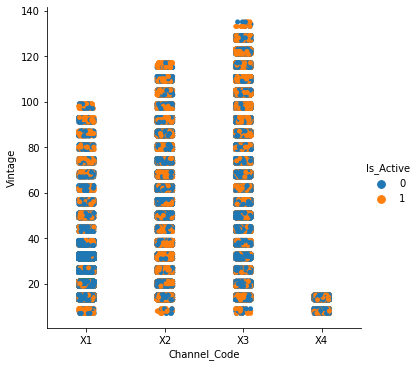

In [32]:
#Finding insights

sns.catplot(y='Vintage',x='Channel_Code',hue='Is_Active',data=df_test)

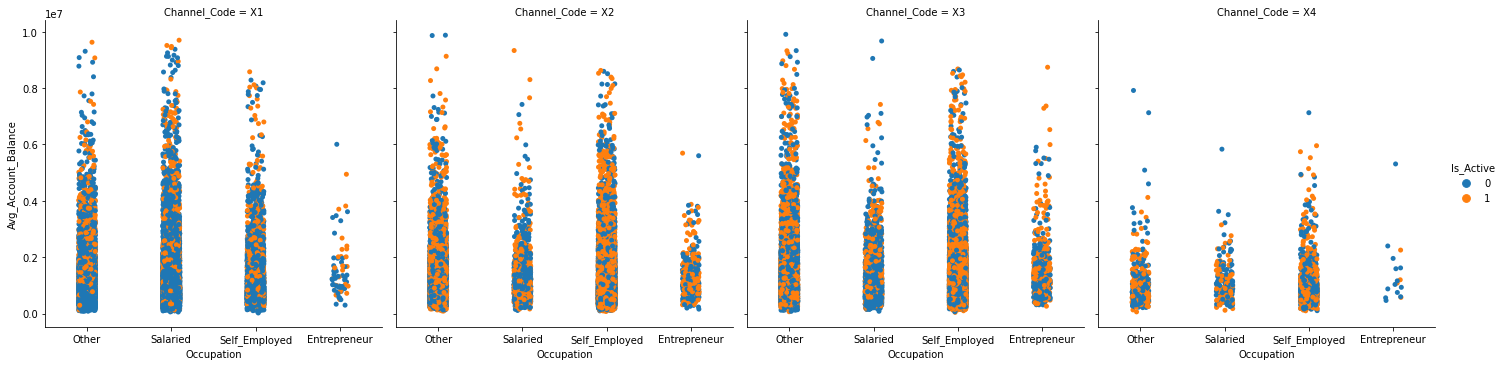

In [33]:
#Checking which channel is active for three months considering the average balance

sns.catplot(y='Avg_Account_Balance',x='Occupation',hue='Is_Active',col='Channel_Code',data=df_test)

In [34]:
#From above visualisation we can say that self employed and others are more active and have good significance 
# in every channel so we will replace according to the significance

df_test['Occupation'].replace(['Self_Employed','Other','Salaried','Entrepreneur'],[4,3,2,1],inplace=True)

In [35]:
#Counting region code as it has multiple categories so we need to find a solution where they can deal with it

df_test['Region_Code'].value_counts()

RG268    15125
RG283    12881
RG254    11737
RG284     8173
RG277     5596
RG280     5529
RG270     3440
RG269     3288
RG261     3286
RG251     2678
RG257     2588
RG272     2338
RG282     2337
RG274     2208
RG281     2144
RG252     1811
RG273     1803
RG263     1615
RG279     1600
RG275     1383
RG260     1300
RG264     1241
RG256     1194
RG276     1185
RG259     1102
RG250     1048
RG255      891
RG278      824
RG258      812
RG253      810
RG262      800
RG265      668
RG271      654
RG266      631
RG267      592
Name: Region_Code, dtype: int64

In [36]:
#Applying one hot encoding in region code 

reg_code=pd.get_dummies(df_test['Region_Code'])
reg_code.head()
df_test = pd.concat([df_test,reg_code],axis=1)

In [37]:
#top_20_region = [x for x in df_test['Region_Code'].value_counts().head(10).index]
#top_20_region

In [38]:
#Taking top 20 Region code doing frequency encoding

#for label in top_20_region:
 #   df_test[label] = np.where(df_test['Region_Code']==label,1,0)
#df_test[['Region_Code'] + top_20_region].head(5)    

In [39]:
#Concatenating region code with original data



In [40]:
# Applying one hot encoding into channel code

ch_code =pd.get_dummies(df_test['Channel_Code'])
ch_code.head()

,X1,X2,X3,X4
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [41]:
#Concatenating channel codes with original data

df_test = pd.concat([df_test,ch_code],axis =1)

In [42]:
#Dropping columns 

df_test.drop(['ID','Region_Code','Channel_Code'],axis =1 ,inplace=True)

In [43]:
df_test.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,RG250,RG251,RG252,...,RG279,RG280,RG281,RG282,RG283,RG284,X1,X2,X3,X4
0,1,29,3,25,1,742366,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,43,3,49,0,925537,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,31,2,14,0,215949,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,29,3,33,0,868070,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,29,3,19,0,657087,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
df_test.isnull().sum()

Gender                 0
Age                    0
Occupation             0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
RG250                  0
RG251                  0
RG252                  0
RG253                  0
RG254                  0
RG255                  0
RG256                  0
RG257                  0
RG258                  0
RG259                  0
RG260                  0
RG261                  0
RG262                  0
RG263                  0
RG264                  0
RG265                  0
RG266                  0
RG267                  0
RG268                  0
RG269                  0
RG270                  0
RG271                  0
RG272                  0
RG273                  0
RG274                  0
RG275                  0
RG276                  0
RG277                  0
RG278                  0
RG279                  0
RG280                  0
RG281                  0
RG282                  0


In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Gender               105312 non-null  int64
 1   Age                  105312 non-null  int64
 2   Occupation           105312 non-null  int64
 3   Vintage              105312 non-null  int64
 4   Credit_Product       105312 non-null  int64
 5   Avg_Account_Balance  105312 non-null  int64
 6   Is_Active            105312 non-null  int64
 7   RG250                105312 non-null  uint8
 8   RG251                105312 non-null  uint8
 9   RG252                105312 non-null  uint8
 10  RG253                105312 non-null  uint8
 11  RG254                105312 non-null  uint8
 12  RG255                105312 non-null  uint8
 13  RG256                105312 non-null  uint8
 14  RG257                105312 non-null  uint8
 15  RG258                105312 non-null  uint8
 16  RG

# Model Preprocessing and Trainning ...

In [46]:
from sklearn.svm import SVC

svc=SVC()

In [47]:
#svc.fit(X_train,y_train)

In [48]:
#print('Accuracy in existing data for Support vector classifier is {}%'.format(round(svc.score(X_test,y_test)*100)))



In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, Y_tr, test_size=0.20, random_state=42)

# Logistic Regression

In [50]:
#fitting the model

LR = LogisticRegression()
LR.fit(X_train,y_train) 

LogisticRegression()

In [51]:
#predicting values based on existing data
y_predict=LR.predict(X_test) 
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
print('Accuracy in existing data for logistic Regression is {}%'.format(round(LR.score(X_test,y_test)*100)))


Accuracy in existing data for logistic Regression is 76%


# Random forest Classifier

In [53]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train) 

RandomForestClassifier()

In [54]:
print('Accuracy in existing data for Random Forest Regression is {}%'.format(round(rfc.score(X_test,y_test)*100)))


Accuracy in existing data for Random Forest Regression is 78%


# KNN

In [55]:
knn=  KNeighborsClassifier()

In [56]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [57]:
print('Accuracy in existing data for KNN is {}%'.format(round(knn.score(X_test,y_test)*100)))


Accuracy in existing data for KNN is 73%


In [58]:
#predicting values based on test data
y_pred=LR.predict(df_test) 
pd.DataFrame(y_pred).value_counts()

0    105312
dtype: int64

In [59]:
y_pre=rfc.predict(df_test)
pd.DataFrame(y_pre).value_counts()

0    91297
1    14015
dtype: int64

In [60]:
submission = pd.read_csv('sample_submission.csv')
final_predictions = rfc.predict(df_test)
submission['Is_Lead'] = final_predictions
#only positive predictions for the target variable
submission.to_csv('my_submission.csv', index=False)

# gradient boosting algorithm

In [61]:
gba = GradientBoostingClassifier()

In [62]:
gba.fit(X_train,y_train)

GradientBoostingClassifier()

In [63]:
print('Accuracy in existing data for KNN is {}%'.format(round(gba.score(X_test,y_test)*100)))


Accuracy in existing data for KNN is 79%


In [64]:
y_pre=gba.predict(df_test)
pd.DataFrame(y_pre).value_counts()

0    97742
1     7570
dtype: int64